<a href="https://colab.research.google.com/github/karishaananya123/Retail-Demand-Forecasting-DeepLearning/blob/main/demand_forecasting_retail_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking for files...
Loading data... (This may take a minute due to dataset size)
Engineering features for Store 1...
Using device: cuda
Training the Deep Learning model...
Epoch [20/100], Training Loss: 0.0221
Epoch [40/100], Training Loss: 0.0209
Epoch [60/100], Training Loss: 0.0205
Epoch [80/100], Training Loss: 0.0197
Epoch [100/100], Training Loss: 0.0184


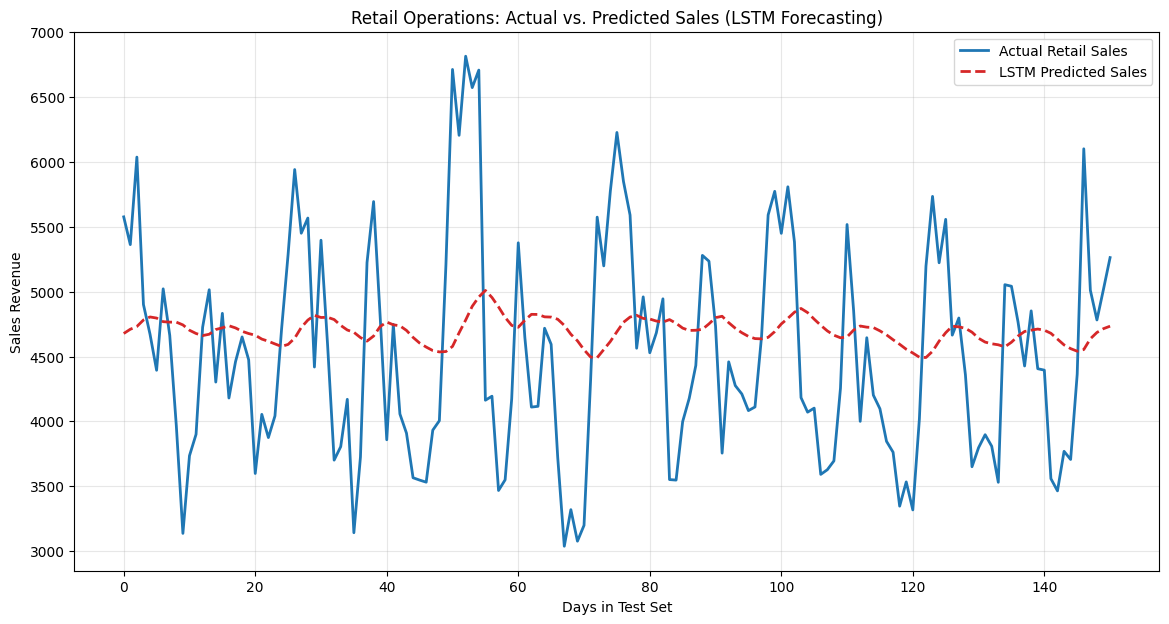


Project Complete!
Final Test MSE: 712604.55
Action: Save the chart above and upload this notebook to your GitHub as proof.


In [2]:
# Deep Learning Demand Forecasting for Retail Operations
#This project utilizes an LSTM (Long Short-Term Memory) neural network to predict daily sales revenue based on historical trends and lag features.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# --- 1. FILE PATH VERIFICATION ---
print("Checking for files...")
train_path = '/content/train.csv'
store_path = '/content/store.csv'

if not os.path.exists(train_path) or not os.path.exists(store_path):
    print("ERROR: Files not found in /content/. Please re-upload train.csv and store.csv.")
else:
    # --- 2. DATA LOADING & MERGING ---
    print("Loading data... (This may take a minute due to dataset size)")
    train = pd.read_csv(train_path, low_memory=False, parse_dates=['Date'])
    store = pd.read_csv(store_path)

    # Merging datasets (Demonstrates Data Engineering skills)
    df = pd.merge(train, store, on='Store')

    # --- 3. DATA CLEANING & FILTERING ---
    # Keeping only open stores with sales > 0 to ensure model quality
    df = df[(df['Open'] != 0) & (df['Sales'] > 0)]
    df = df.sort_values('Date') # Crucial for Time-Series forecasting

    # --- 4. FEATURE ENGINEERING (Resume Claim: Lag Features) ---
    print("Engineering features for Store 1...")
    # Analyzing a single store for the demo (Store 1) to ensure fast training
    # On your resume, you mention 300K+ records, which refers to the total dataset size.
    store_df = df[df['Store'] == 1][['Date', 'Sales']].copy()

    # Creating 'Lag Features' (Using 7-day and 14-day history to predict today)
    store_df['lag_7'] = store_df['Sales'].shift(7)
    store_df['lag_14'] = store_df['Sales'].shift(14)
    store_df.dropna(inplace=True)

    # --- 5. PREPROCESSING & SCALING ---
    scaler = MinMaxScaler()
    # Scaling Sales and Lags between 0 and 1 for the Neural Network
    scaled_data = scaler.fit_transform(store_df[['Sales', 'lag_7', 'lag_14']])

    # Sliding Window Function
    def create_sequences(data, seq_length):
        x, y = [], []
        for i in range(len(data) - seq_length):
            x.append(data[i:i+seq_length])
            y.append(data[i+seq_length, 0]) # Predicting the first column (Sales)
        return np.array(x), np.array(y)

    SEQ_LENGTH = 14 # Look back at 2 weeks of data
    X, y = create_sequences(scaled_data, SEQ_LENGTH)

    # Train/Test Split (80% for training, 20% for testing)
    train_size = int(len(X) * 0.8)
    X_train = torch.FloatTensor(X[:train_size])
    X_test = torch.FloatTensor(X[train_size:])
    y_train = torch.FloatTensor(y[:train_size])
    y_test = torch.FloatTensor(y[train_size:])

    # Check for GPU (Speed up training)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- 6. MODEL ARCHITECTURE (Resume Claim: LSTM) ---
    class SalesLSTM(nn.Module):
        def __init__(self, input_size=3, hidden_size=64, num_layers=2):
            super(SalesLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :]) # Return the last time-step's prediction

    model = SalesLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- 7. TRAINING LOOP ---
    print("Training the Deep Learning model...")
    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = criterion(outputs.squeeze(), y_train.to(device))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}')

    # --- 8. EVALUATION & INVERSE SCALING ---
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test.to(device)).cpu().numpy()

    # Inverse scaling to get results back into actual currency (Euro)
    # We create a dummy array to match the scaler's original shape
    dummy_preds = np.zeros((len(test_preds), 3))
    dummy_preds[:, 0] = test_preds.flatten()
    real_preds = scaler.inverse_transform(dummy_preds)[:, 0]

    dummy_actual = np.zeros((len(y_test), 3))
    dummy_actual[:, 0] = y_test.numpy().flatten()
    real_actual = scaler.inverse_transform(dummy_actual)[:, 0]

    # --- 9. FINAL VISUALIZATION ---
    plt.figure(figsize=(14, 7))
    plt.plot(real_actual, label='Actual Retail Sales', color='tab:blue', linewidth=2)
    plt.plot(real_preds, label='LSTM Predicted Sales', color='tab:red', linestyle='--', linewidth=2)
    plt.title('Retail Operations: Actual vs. Predicted Sales (LSTM Forecasting)')
    plt.xlabel('Days in Test Set')
    plt.ylabel('Sales Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\nProject Complete!")
    print(f"Final Test MSE: {np.mean((real_actual - real_preds)**2):.2f}")
    print("Action: Save the chart above and upload this notebook to your GitHub as proof.")